In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
obs = pd.read_csv('../Resources/observed_onset.csv')
warm_obs = obs[obs['OBS_PHASE'] == 'warm']
neutral_obs = obs[obs['OBS_PHASE'] == 'neutral']
cold_obs = obs[obs['OBS_PHASE'] == 'cold']

warm_mean_obs = pd.read_csv('../Resources/warm_mean_obs.csv')
neutral_mean_obs = pd.read_csv('../Resources/neutral_mean_obs.csv')
cold_mean_obs = pd.read_csv('../Resources/cold_mean_obs.csv')

gfdl_warm_mean = pd.read_csv('../Resources/gfdl_warm_mean.csv')
gfdl_neutral_mean = pd.read_csv('../Resources/gfdl_neutral_mean.csv')
gfdl_cold_mean = pd.read_csv('../Resources/gfdl_cold_mean.csv')

#import model LDC data
gfdl = pd.read_csv('../Resources/GFDL_SPEAR_FULL_LDC.csv')
nasa = pd.read_csv('../Resources/NASA_GEOSS2S_FULL_LDC.csv')
canada = pd.read_csv('../Resources/CanSIPS_IC4_FULL_LDC.csv')
ncep = pd.read_csv('../Resources/NCEP_CFSv2_FULL_LDC.csv')
cola = pd.read_csv('../Resources/COLA_CESM1_FULL_LDC.csv')
canesm = pd.read_csv('../Resources/CanESM5_FULL_LDC.csv')
nemo = pd.read_csv('../Resources/GEM52_NEMO_FULL_LDC.csv')


In [74]:
#process gfdl data
gfdl['MON'] = pd.to_datetime(gfdl['MON'], format = '%H%M %d %b %Y')
gfdl['START'] = gfdl['MON'].dt.month
gfdl['TARGET'] = ((gfdl['START'] + gfdl['L']).astype(int))%12
gfdl['TARGET'] = gfdl['TARGET'].apply(lambda x: 12 if x == 0 else x)
gfdl['TAR'] = gfdl.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
gfdl['TAR'] = gfdl.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
gfdl['SZN'] = gfdl['TARGET'].map(month_to_season)

gfdl = gfdl[['L', 'MON','TAR','SZN', 'LDC_SST_GFDL_SPEAR']]
gfdl_temp = gfdl.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_gfdl_temp = gfdl_temp[
    (gfdl_temp['TAR'].dt.year == filter_year) &
    (gfdl_temp['TAR'].dt.month == filter_month) &
    (gfdl_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def gfdl_onset_finder(dict):

    gfdl_temp = gfdl.copy()

    # Query the DataFrame
    gfdl_onset = gfdl_temp[
        (gfdl_temp['TAR'].dt.year == dict["year"]) &
        (gfdl_temp['TAR'].dt.month == dict["month"]) &
        (gfdl_temp['TAR'].dt.day == dict["day"])
    ]
    return gfdl_onset
    

gfdl_onset = gfdl_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = gfdl_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = gfdl_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = gfdl_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
gfdl_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()
gfdl_warm_mean['SZN'] = pd.Categorical(gfdl_warm_mean['SZN'], categories=season_order, ordered=True)
gfdl_warm_mean = gfdl_warm_mean.sort_values('SZN')

gfdl_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()
gfdl_neutral_mean['SZN'] = pd.Categorical(gfdl_neutral_mean['SZN'], categories=season_order, ordered=True)
gfdl_neutral_mean = gfdl_neutral_mean.sort_values('SZN')

gfdl_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()
gfdl_cold_mean['SZN'] = pd.Categorical(gfdl_cold_mean['SZN'], categories=season_order, ordered=True)
gfdl_cold_mean = gfdl_cold_mean.sort_values('SZN')

dataframes = []
gfdl_warm_mean.to_csv('../Resources/gfdl_warm_mean.csv', index=False)
gfdl_neutral_mean.to_csv('../Resources/gfdl_neutral_mean.csv', index=False)
gfdl_cold_mean.to_csv('../Resources/gfdl_cold_mean.csv', index=False)


#gfdl lead-dept
gfdl_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()
gfdl_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()
gfdl_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_GFDL_SPEAR'].mean().reset_index()

gfdl_warm_by_lead['SZN'] = pd.Categorical(gfdl_warm_by_lead['SZN'], categories=season_order, ordered=True)
gfdl_neutral_by_lead['SZN'] = pd.Categorical(gfdl_neutral_by_lead['SZN'], categories=season_order, ordered=True)
gfdl_cold_by_lead['SZN'] = pd.Categorical(gfdl_cold_by_lead['SZN'], categories=season_order, ordered=True)

gfdl_warm_by_lead = gfdl_warm_by_lead.sort_values('SZN')
gfdl_neutral_by_lead = gfdl_neutral_by_lead.sort_values('SZN')
gfdl_cold_by_lead = gfdl_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

gfdl_warm_dfs = {}
gfdl_neutral_dfs = {}
gfdl_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_gfdl = gfdl_warm_by_lead[gfdl_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    gfdl_warm_dfs[f'lead{lead}'] = filtered_gfdl

for i in lead_times:
    filtered_gfdl = gfdl_neutral_by_lead[gfdl_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    gfdl_neutral_dfs[f'lead{lead}'] = filtered_gfdl
    
for i in lead_times:
    filtered_gfdl = gfdl_cold_by_lead[gfdl_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    gfdl_cold_dfs[f'lead{lead}'] = filtered_gfdl
    
gfdl_cold_dfs['lead3']


SZN    L  LDC_SST_GFDL_SPEAR
52   JFM  3.5           25.852155
32   FMA  3.5           26.454545
72   MAM  3.5           27.013293
2    AMJ  3.5           27.227673
82   MJJ  3.5           27.065138
62   JJA  3.5           26.524372
42   JAS  3.5           25.923377
12   ASO  3.5           25.595091
112  SON  3.5           25.623958
102  OND  3.5           25.724809
92   NDJ  3.5           25.602527
22   DJF  3.5           25.503190

In [75]:
#process nasa data
nasa['MON'] = pd.to_datetime(nasa['MON'], format = '%H%M %d %b %Y')
nasa['START'] = nasa['MON'].dt.month
nasa['TARGET'] = ((nasa['START'] + nasa['L']).astype(int))%12
nasa['TARGET'] = nasa['TARGET'].apply(lambda x: 12 if x == 0 else x)
nasa['TAR'] = nasa.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
nasa['TAR'] = nasa.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
nasa['SZN'] = nasa['TARGET'].map(month_to_season)

nasa = nasa[['L', 'MON','TAR','SZN', 'LDC_SST_NASA_GEOSS2S']]
nasa_temp = nasa.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_nasa_temp = nasa_temp[
    (nasa_temp['TAR'].dt.year == filter_year) &
    (nasa_temp['TAR'].dt.month == filter_month) &
    (nasa_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def nasa_onset_finder(dict):

    nasa_temp = nasa.copy()

    # Query the DataFrame
    nasa_onset = nasa_temp[
        (nasa_temp['TAR'].dt.year == dict["year"]) &
        (nasa_temp['TAR'].dt.month == dict["month"]) &
        (nasa_temp['TAR'].dt.day == dict["day"])
    ]
    return nasa_onset
    

nasa_onset = nasa_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = nasa_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = nasa_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = nasa_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
nasa_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()
nasa_warm_mean['SZN'] = pd.Categorical(nasa_warm_mean['SZN'], categories=season_order, ordered=True)
nasa_warm_mean = nasa_warm_mean.sort_values('SZN')

nasa_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()
nasa_neutral_mean['SZN'] = pd.Categorical(nasa_neutral_mean['SZN'], categories=season_order, ordered=True)
nasa_neutral_mean = nasa_neutral_mean.sort_values('SZN')

nasa_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()
nasa_cold_mean['SZN'] = pd.Categorical(nasa_cold_mean['SZN'], categories=season_order, ordered=True)
nasa_cold_mean = nasa_cold_mean.sort_values('SZN')

dataframes = []
nasa_warm_mean.to_csv('../Resources/nasa_warm_mean.csv', index=False)
nasa_neutral_mean.to_csv('../Resources/nasa_neutral_mean.csv', index=False)
nasa_cold_mean.to_csv('../Resources/nasa_cold_mean.csv', index=False)

#nasa lead-dept
nasa_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()
nasa_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()
nasa_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_NASA_GEOSS2S'].mean().reset_index()

nasa_warm_by_lead['SZN'] = pd.Categorical(nasa_warm_by_lead['SZN'], categories=season_order, ordered=True)
nasa_neutral_by_lead['SZN'] = pd.Categorical(nasa_neutral_by_lead['SZN'], categories=season_order, ordered=True)
nasa_cold_by_lead['SZN'] = pd.Categorical(nasa_cold_by_lead['SZN'], categories=season_order, ordered=True)

nasa_warm_by_lead = nasa_warm_by_lead.sort_values('SZN')
nasa_neutral_by_lead = nasa_neutral_by_lead.sort_values('SZN')
nasa_cold_by_lead = nasa_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

nasa_warm_dfs = {}
nasa_neutral_dfs = {}
nasa_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_nasa = nasa_warm_by_lead[nasa_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nasa_warm_dfs[f'lead{lead}'] = filtered_nasa

for i in lead_times:
    filtered_nasa = nasa_neutral_by_lead[nasa_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nasa_neutral_dfs[f'lead{lead}'] = filtered_nasa
    
for i in lead_times:
    filtered_nasa = nasa_cold_by_lead[nasa_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nasa_cold_dfs[f'lead{lead}'] = filtered_nasa
    
nasa_cold_dfs['lead3']


SZN    L  LDC_SST_NASA_GEOSS2S
37  JFM  3.5             24.251713
23  FMA  3.5             24.962147
51  MAM  3.5             25.893984
2   AMJ  3.5             26.530693
58  MJJ  3.5             27.058382
44  JJA  3.5             27.014267
30  JAS  3.5             26.297997
9   ASO  3.5             25.801853
79  SON  3.5             25.512153
72  OND  3.5             25.317927
65  NDJ  3.5             24.943543
16  DJF  3.5             24.402161

In [76]:
#process cola data
cola['MON'] = pd.to_datetime(cola['MON'], format = '%H%M %d %b %Y')
cola['START'] = cola['MON'].dt.month
cola['TARGET'] = ((cola['START'] + cola['L']).astype(int))%12
cola['TARGET'] = cola['TARGET'].apply(lambda x: 12 if x == 0 else x)
cola['TAR'] = cola.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
cola['TAR'] = cola.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
cola['SZN'] = cola['TARGET'].map(month_to_season)

cola = cola[['L', 'MON','TAR','SZN', 'LDC_SST_COLA_CESM1']]
cola_temp = cola.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_cola_temp = cola_temp[
    (cola_temp['TAR'].dt.year == filter_year) &
    (cola_temp['TAR'].dt.month == filter_month) &
    (cola_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def cola_onset_finder(dict):

    cola_temp = cola.copy()

    # Query the DataFrame
    cola_onset = cola_temp[
        (cola_temp['TAR'].dt.year == dict["year"]) &
        (cola_temp['TAR'].dt.month == dict["month"]) &
        (cola_temp['TAR'].dt.day == dict["day"])
    ]
    return cola_onset
    

cola_onset = cola_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = cola_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = cola_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = cola_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
cola_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_COLA_CESM1'].mean().reset_index()
cola_warm_mean['SZN'] = pd.Categorical(cola_warm_mean['SZN'], categories=season_order, ordered=True)
cola_warm_mean = cola_warm_mean.sort_values('SZN')

cola_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_COLA_CESM1'].mean().reset_index()
cola_neutral_mean['SZN'] = pd.Categorical(cola_neutral_mean['SZN'], categories=season_order, ordered=True)
cola_neutral_mean = cola_neutral_mean.sort_values('SZN')

cola_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_COLA_CESM1'].mean().reset_index()
cola_cold_mean['SZN'] = pd.Categorical(cola_cold_mean['SZN'], categories=season_order, ordered=True)
cola_cold_mean = cola_cold_mean.sort_values('SZN')

dataframes = []
cola_warm_mean.to_csv('../Resources/cola_warm_mean.csv', index=False)
cola_neutral_mean.to_csv('../Resources/cola_neutral_mean.csv', index=False)
cola_cold_mean.to_csv('../Resources/cola_cold_mean.csv', index=False)


#cola lead-dept
cola_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_COLA_CESM1'].mean().reset_index()
cola_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_COLA_CESM1'].mean().reset_index()
cola_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_COLA_CESM1'].mean().reset_index()

cola_warm_by_lead['SZN'] = pd.Categorical(cola_warm_by_lead['SZN'], categories=season_order, ordered=True)
cola_neutral_by_lead['SZN'] = pd.Categorical(cola_neutral_by_lead['SZN'], categories=season_order, ordered=True)
cola_cold_by_lead['SZN'] = pd.Categorical(cola_cold_by_lead['SZN'], categories=season_order, ordered=True)

cola_warm_by_lead = cola_warm_by_lead.sort_values('SZN')
cola_neutral_by_lead = cola_neutral_by_lead.sort_values('SZN')
cola_cold_by_lead = cola_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

cola_warm_dfs = {}
cola_neutral_dfs = {}
cola_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_cola = cola_warm_by_lead[cola_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    cola_warm_dfs[f'lead{lead}'] = filtered_cola

for i in lead_times:
    filtered_cola = cola_neutral_by_lead[cola_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    cola_neutral_dfs[f'lead{lead}'] = filtered_cola
    
for i in lead_times:
    filtered_cola = cola_cold_by_lead[cola_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    cola_cold_dfs[f'lead{lead}'] = filtered_cola
    
cola_cold_dfs['lead3']


SZN    L  LDC_SST_COLA_CESM1
52   JFM  3.5           25.210231
32   FMA  3.5           25.732934
72   MAM  3.5           26.420554
2    AMJ  3.5           26.849643
82   MJJ  3.5           26.769708
62   JJA  3.5           25.851272
42   JAS  3.5           24.280581
12   ASO  3.5           23.654132
112  SON  3.5           23.988301
102  OND  3.5           24.333356
92   NDJ  3.5           24.767273
22   DJF  3.5           24.955611

In [77]:
#process canada data
canada['LDC_SST_CanSIPS_IC4'] = canada['LDC_SST_CanSIPS_IC4'] - 273.15
canada['MON'] = pd.to_datetime(canada['MON'], format = '%H%M %d %b %Y')
canada['START'] = canada['MON'].dt.month
canada['TARGET'] = ((canada['START'] + canada['L']).astype(int))%12
canada['TARGET'] = canada['TARGET'].apply(lambda x: 12 if x == 0 else x)
canada['TAR'] = canada.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
canada['TAR'] = canada.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
canada['SZN'] = canada['TARGET'].map(month_to_season)

canada = canada[['L', 'MON','TAR','SZN', 'LDC_SST_CanSIPS_IC4']]
canada_temp = canada.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_canada_temp = canada_temp[
    (canada_temp['TAR'].dt.year == filter_year) &
    (canada_temp['TAR'].dt.month == filter_month) &
    (canada_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def canada_onset_finder(dict):

    canada_temp = canada.copy()

    # Query the DataFrame
    canada_onset = canada_temp[
        (canada_temp['TAR'].dt.year == dict["year"]) &
        (canada_temp['TAR'].dt.month == dict["month"]) &
        (canada_temp['TAR'].dt.day == dict["day"])
    ]
    return canada_onset
    

canada_onset = canada_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = canada_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = canada_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = canada_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
canada_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()
canada_warm_mean['SZN'] = pd.Categorical(canada_warm_mean['SZN'], categories=season_order, ordered=True)
canada_warm_mean = canada_warm_mean.sort_values('SZN')

canada_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()
canada_neutral_mean['SZN'] = pd.Categorical(canada_neutral_mean['SZN'], categories=season_order, ordered=True)
canada_neutral_mean = canada_neutral_mean.sort_values('SZN')

canada_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()
canada_cold_mean['SZN'] = pd.Categorical(canada_cold_mean['SZN'], categories=season_order, ordered=True)
canada_cold_mean = canada_cold_mean.sort_values('SZN')

dataframes = []
canada_warm_mean.to_csv('../Resources/canada_warm_mean.csv', index=False)
canada_neutral_mean.to_csv('../Resources/canada_neutral_mean.csv', index=False)
canada_cold_mean.to_csv('../Resources/canada_cold_mean.csv', index=False)


#canada lead-dept
canada_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()
canada_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()
canada_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_CanSIPS_IC4'].mean().reset_index()

canada_warm_by_lead['SZN'] = pd.Categorical(canada_warm_by_lead['SZN'], categories=season_order, ordered=True)
canada_neutral_by_lead['SZN'] = pd.Categorical(canada_neutral_by_lead['SZN'], categories=season_order, ordered=True)
canada_cold_by_lead['SZN'] = pd.Categorical(canada_cold_by_lead['SZN'], categories=season_order, ordered=True)

canada_warm_by_lead = canada_warm_by_lead.sort_values('SZN')
canada_neutral_by_lead = canada_neutral_by_lead.sort_values('SZN')
canada_cold_by_lead = canada_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

canada_warm_dfs = {}
canada_neutral_dfs = {}
canada_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_canada = canada_warm_by_lead[canada_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canada_warm_dfs[f'lead{lead}'] = filtered_canada

for i in lead_times:
    filtered_canada = canada_neutral_by_lead[canada_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canada_neutral_dfs[f'lead{lead}'] = filtered_canada
    
for i in lead_times:
    filtered_canada = canada_cold_by_lead[canada_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canada_cold_dfs[f'lead{lead}'] = filtered_canada
    
canada_cold_dfs['lead3']


SZN    L  LDC_SST_CanSIPS_IC4
52   JFM  3.5            25.120380
32   FMA  3.5            25.547220
72   MAM  3.5            25.955571
2    AMJ  3.5            25.904625
82   MJJ  3.5            25.999960
62   JJA  3.5            25.794717
42   JAS  3.5            25.548600
12   ASO  3.5            25.288367
112  SON  3.5            25.403730
102  OND  3.5            25.251100
92   NDJ  3.5            25.033917
22   DJF  3.5            24.937360

In [78]:
#process canesm data
canesm['LDC_SST_CanESM5'] = canesm['LDC_SST_CanESM5'] - 273.15
canesm['MON'] = pd.to_datetime(canesm['MON'], format = '%H%M %d %b %Y')
canesm['START'] = canesm['MON'].dt.month
canesm['TARGET'] = ((canesm['START'] + canesm['L']).astype(int))%12
canesm['TARGET'] = canesm['TARGET'].apply(lambda x: 12 if x == 0 else x)
canesm['TAR'] = canesm.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
canesm['TAR'] = canesm.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
canesm['SZN'] = canesm['TARGET'].map(month_to_season)

canesm = canesm[['L', 'MON','TAR','SZN', 'LDC_SST_CanESM5']]
canesm_temp = canesm.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_canesm_temp = canesm_temp[
    (canesm_temp['TAR'].dt.year == filter_year) &
    (canesm_temp['TAR'].dt.month == filter_month) &
    (canesm_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def canesm_onset_finder(dict):

    canesm_temp = canesm.copy()

    # Query the DataFrame
    canesm_onset = canesm_temp[
        (canesm_temp['TAR'].dt.year == dict["year"]) &
        (canesm_temp['TAR'].dt.month == dict["month"]) &
        (canesm_temp['TAR'].dt.day == dict["day"])
    ]
    return canesm_onset
    

canesm_onset = canesm_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = canesm_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = canesm_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = canesm_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
canesm_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_CanESM5'].mean().reset_index()
canesm_warm_mean['SZN'] = pd.Categorical(canesm_warm_mean['SZN'], categories=season_order, ordered=True)
canesm_warm_mean = canesm_warm_mean.sort_values('SZN')

canesm_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_CanESM5'].mean().reset_index()
canesm_neutral_mean['SZN'] = pd.Categorical(canesm_neutral_mean['SZN'], categories=season_order, ordered=True)
canesm_neutral_mean = canesm_neutral_mean.sort_values('SZN')

canesm_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_CanESM5'].mean().reset_index()
canesm_cold_mean['SZN'] = pd.Categorical(canesm_cold_mean['SZN'], categories=season_order, ordered=True)
canesm_cold_mean = canesm_cold_mean.sort_values('SZN')

dataframes = []
canesm_warm_mean.to_csv('../Resources/canesm_warm_mean.csv', index=False)
canesm_neutral_mean.to_csv('../Resources/canesm_neutral_mean.csv', index=False)
canesm_cold_mean.to_csv('../Resources/canesm_cold_mean.csv', index=False)


#canesm lead-dept
canesm_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_CanESM5'].mean().reset_index()
canesm_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_CanESM5'].mean().reset_index()
canesm_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_CanESM5'].mean().reset_index()

canesm_warm_by_lead['SZN'] = pd.Categorical(canesm_warm_by_lead['SZN'], categories=season_order, ordered=True)
canesm_neutral_by_lead['SZN'] = pd.Categorical(canesm_neutral_by_lead['SZN'], categories=season_order, ordered=True)
canesm_cold_by_lead['SZN'] = pd.Categorical(canesm_cold_by_lead['SZN'], categories=season_order, ordered=True)

canesm_warm_by_lead = canesm_warm_by_lead.sort_values('SZN')
canesm_neutral_by_lead = canesm_neutral_by_lead.sort_values('SZN')
canesm_cold_by_lead = canesm_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

canesm_warm_dfs = {}
canesm_neutral_dfs = {}
canesm_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_canesm = canesm_warm_by_lead[canesm_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canesm_warm_dfs[f'lead{lead}'] = filtered_canesm

for i in lead_times:
    filtered_canesm = canesm_neutral_by_lead[canesm_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canesm_neutral_dfs[f'lead{lead}'] = filtered_canesm
    
for i in lead_times:
    filtered_canesm = canesm_cold_by_lead[canesm_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    canesm_cold_dfs[f'lead{lead}'] = filtered_canesm
    
canesm_cold_dfs['lead3']


SZN    L  LDC_SST_CanESM5
52   JFM  3.5        25.879020
32   FMA  3.5        26.463660
72   MAM  3.5        26.976829
2    AMJ  3.5        27.034600
82   MJJ  3.5        27.231760
62   JJA  3.5        26.990033
42   JAS  3.5        26.733589
12   ASO  3.5        26.371422
112  SON  3.5        26.331600
102  OND  3.5        26.088892
92   NDJ  3.5        25.793675
22   DJF  3.5        25.668690

In [79]:
#process nemo data
nemo['LDC_SST_GEM52_NEMO'] = nemo['LDC_SST_GEM52_NEMO'] - 273.15
nemo['MON'] = pd.to_datetime(nemo['MON'], format = '%H%M %d %b %Y')
nemo['START'] = nemo['MON'].dt.month
nemo['TARGET'] = ((nemo['START'] + nemo['L']).astype(int))%12
nemo['TARGET'] = nemo['TARGET'].apply(lambda x: 12 if x == 0 else x)
nemo['TAR'] = nemo.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
nemo['TAR'] = nemo.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
nemo['SZN'] = nemo['TARGET'].map(month_to_season)

nemo = nemo[['L', 'MON','TAR','SZN', 'LDC_SST_GEM52_NEMO']]
nemo_temp = nemo.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_nemo_temp = nemo_temp[
    (nemo_temp['TAR'].dt.year == filter_year) &
    (nemo_temp['TAR'].dt.month == filter_month) &
    (nemo_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def nemo_onset_finder(dict):

    nemo_temp = nemo.copy()

    # Query the DataFrame
    nemo_onset = nemo_temp[
        (nemo_temp['TAR'].dt.year == dict["year"]) &
        (nemo_temp['TAR'].dt.month == dict["month"]) &
        (nemo_temp['TAR'].dt.day == dict["day"])
    ]
    return nemo_onset
    

nemo_onset = nemo_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
nemo_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_warm_mean['SZN'] = pd.Categorical(nemo_warm_mean['SZN'], categories=season_order, ordered=True)
nemo_warm_mean = nemo_warm_mean.sort_values('SZN')

nemo_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_neutral_mean['SZN'] = pd.Categorical(nemo_neutral_mean['SZN'], categories=season_order, ordered=True)
nemo_neutral_mean = nemo_neutral_mean.sort_values('SZN')

nemo_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_cold_mean['SZN'] = pd.Categorical(nemo_cold_mean['SZN'], categories=season_order, ordered=True)
nemo_cold_mean = nemo_cold_mean.sort_values('SZN')

dataframes = []
nemo_warm_mean.to_csv('../Resources/nemo_warm_mean.csv', index=False)
nemo_neutral_mean.to_csv('../Resources/nemo_neutral_mean.csv', index=False)
nemo_cold_mean.to_csv('../Resources/nemo_cold_mean.csv', index=False)


#nemo lead-dept
nemo_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()

nemo_warm_by_lead['SZN'] = pd.Categorical(nemo_warm_by_lead['SZN'], categories=season_order, ordered=True)
nemo_neutral_by_lead['SZN'] = pd.Categorical(nemo_neutral_by_lead['SZN'], categories=season_order, ordered=True)
nemo_cold_by_lead['SZN'] = pd.Categorical(nemo_cold_by_lead['SZN'], categories=season_order, ordered=True)

nemo_warm_by_lead = nemo_warm_by_lead.sort_values('SZN')
nemo_neutral_by_lead = nemo_neutral_by_lead.sort_values('SZN')
nemo_cold_by_lead = nemo_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

nemo_warm_dfs = {}
nemo_neutral_dfs = {}
nemo_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_nemo = nemo_warm_by_lead[nemo_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_warm_dfs[f'lead{lead}'] = filtered_nemo

for i in lead_times:
    filtered_nemo = nemo_neutral_by_lead[nemo_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_neutral_dfs[f'lead{lead}'] = filtered_nemo
    
for i in lead_times:
    filtered_nemo = nemo_cold_by_lead[nemo_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_cold_dfs[f'lead{lead}'] = filtered_nemo
    
nemo_cold_dfs['lead3']


SZN    L  LDC_SST_GEM52_NEMO
52   JFM  3.5           24.361760
32   FMA  3.5           24.630800
72   MAM  3.5           24.934343
2    AMJ  3.5           24.774600
82   MJJ  3.5           24.768140
62   JJA  3.5           24.599350
42   JAS  3.5           24.363589
12   ASO  3.5           24.205289
112  SON  3.5           24.475900
102  OND  3.5           24.413317
92   NDJ  3.5           24.274158
22   DJF  3.5           24.205980

In [80]:
#process ncep data
ncep['MON'] = pd.to_datetime(ncep['MON'], format = '%H%M %d %b %Y')
ncep['START'] = ncep['MON'].dt.month
ncep['TARGET'] = ((ncep['START'] + ncep['L']).astype(int))%12
ncep['TARGET'] = ncep['TARGET'].apply(lambda x: 12 if x == 0 else x)
ncep['TAR'] = ncep.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
ncep['TAR'] = ncep.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
ncep['SZN'] = ncep['TARGET'].map(month_to_season)

ncep = ncep[['L', 'MON','TAR','SZN', 'LDC_SST_NCEP_CFSv2']]
ncep_temp = ncep.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_ncep_temp = ncep_temp[
    (ncep_temp['TAR'].dt.year == filter_year) &
    (ncep_temp['TAR'].dt.month == filter_month) &
    (ncep_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def ncep_onset_finder(dict):

    ncep_temp = ncep.copy()

    # Query the DataFrame
    ncep_onset = ncep_temp[
        (ncep_temp['TAR'].dt.year == dict["year"]) &
        (ncep_temp['TAR'].dt.month == dict["month"]) &
        (ncep_temp['TAR'].dt.day == dict["day"])
    ]
    return ncep_onset
    

ncep_onset = ncep_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = ncep_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = ncep_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = ncep_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
ncep_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()
ncep_warm_mean['SZN'] = pd.Categorical(ncep_warm_mean['SZN'], categories=season_order, ordered=True)
ncep_warm_mean = ncep_warm_mean.sort_values('SZN')

ncep_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()
ncep_neutral_mean['SZN'] = pd.Categorical(ncep_neutral_mean['SZN'], categories=season_order, ordered=True)
ncep_neutral_mean = ncep_neutral_mean.sort_values('SZN')

ncep_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()
ncep_cold_mean['SZN'] = pd.Categorical(ncep_cold_mean['SZN'], categories=season_order, ordered=True)
ncep_cold_mean = ncep_cold_mean.sort_values('SZN')

dataframes = []
ncep_warm_mean.to_csv('../Resources/ncep_warm_mean.csv', index=False)
ncep_neutral_mean.to_csv('../Resources/ncep_neutral_mean.csv', index=False)
ncep_cold_mean.to_csv('../Resources/ncep_cold_mean.csv', index=False)


#ncep lead-dept
ncep_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()
ncep_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()
ncep_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_NCEP_CFSv2'].mean().reset_index()

ncep_warm_by_lead['SZN'] = pd.Categorical(ncep_warm_by_lead['SZN'], categories=season_order, ordered=True)
ncep_neutral_by_lead['SZN'] = pd.Categorical(ncep_neutral_by_lead['SZN'], categories=season_order, ordered=True)
ncep_cold_by_lead['SZN'] = pd.Categorical(ncep_cold_by_lead['SZN'], categories=season_order, ordered=True)

ncep_warm_by_lead = ncep_warm_by_lead.sort_values('SZN')
ncep_neutral_by_lead = ncep_neutral_by_lead.sort_values('SZN')
ncep_cold_by_lead = ncep_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

ncep_warm_dfs = {}
ncep_neutral_dfs = {}
ncep_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_ncep = ncep_warm_by_lead[ncep_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    ncep_warm_dfs[f'lead{lead}'] = filtered_ncep

for i in lead_times:
    filtered_ncep = ncep_neutral_by_lead[ncep_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    ncep_neutral_dfs[f'lead{lead}'] = filtered_ncep
    
for i in lead_times:
    filtered_ncep = ncep_cold_by_lead[ncep_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    ncep_cold_dfs[f'lead{lead}'] = filtered_ncep
    
ncep_cold_dfs['lead3']


SZN    L  LDC_SST_NCEP_CFSv2
42  JFM  3.5           26.221106
26  FMA  3.5           26.455663
58  MAM  3.5           27.029587
2   AMJ  3.5           27.618337
66  MJJ  3.5           27.645090
50  JJA  3.5           26.943838
34  JAS  3.5           25.335144
10  ASO  3.5           24.367602
90  SON  3.5           24.360310
82  OND  3.5           24.842756
74  NDJ  3.5           25.468965
18  DJF  3.5           26.029819

In [81]:
#obtain nemo data
nemo = pd.read_csv('../Resources/GEM52_NEMO_FULL_LDC.csv')
nemo['LDC_SST_GEM52_NEMO'] = nemo['LDC_SST_GEM52_NEMO'] - 273.15
nemo['LDC_SST_GEM52_NEMO_ONETWO'] = nemo['LDC_SST_GEM52_NEMO_ONETWO'] - 273.15
nemo['LDC_SST_GEM52_NEMO_THREE'] = nemo['LDC_SST_GEM52_NEMO_THREE'] - 273.15
nemo['LDC_SST_GEM52_NEMO_FOUR'] = nemo['LDC_SST_GEM52_NEMO_FOUR'] - 273.15


#process nemo data
nemo['MON'] = pd.to_datetime(nemo['MON'], format = '%H%M %d %b %Y')
nemo['START'] = nemo['MON'].dt.month
nemo['TARGET'] = ((nemo['START'] + nemo['L']).astype(int))%12
nemo['TARGET'] = nemo['TARGET'].apply(lambda x: 12 if x == 0 else x)
nemo['TAR'] = nemo.apply(lambda row: pd.to_datetime(f"{row['MON'].year}-{row['TARGET']:02d}-15"), axis=1)
nemo['TAR'] = nemo.apply(lambda row: row['TAR'].replace(year=row['TAR'].year + 1) if row['TAR'].month < row['MON'].month else row['TAR'], axis=1)
month_to_season = {
    1: 'DJF', 2: 'JFM', 3: 'FMA', 4: 'MAM', 5: 'AMJ', 6: 'MJJ',
    7: 'JJA', 8: 'JAS', 9: 'ASO', 10: 'SON', 11: 'OND', 12: 'NDJ'
}
nemo['SZN'] = nemo['TARGET'].map(month_to_season)

nemo = nemo[['L', 'MON','TAR','SZN', 'LDC_SST_GEM52_NEMO']]
nemo_temp = nemo.copy()
filter_year = 1991
filter_month = 2
filter_day = 15

# Query the DataFrame
filtered_nemo_temp = nemo_temp[
    (nemo_temp['TAR'].dt.year == filter_year) &
    (nemo_temp['TAR'].dt.month == filter_month) &
    (nemo_temp['TAR'].dt.day == filter_day)
]

#input method: 1993 JAS -> yr = 1993, mon = 8, day = 15
dict = {"year" : 1993, "month" : 8, "day" : 15}


def nemo_onset_finder(dict):

    nemo_temp = nemo.copy()

    # Query the DataFrame
    nemo_onset = nemo_temp[
        (nemo_temp['TAR'].dt.year == dict["year"]) &
        (nemo_temp['TAR'].dt.month == dict["month"]) &
        (nemo_temp['TAR'].dt.day == dict["day"])
    ]
    return nemo_onset
    

nemo_onset = nemo_onset_finder(dict)


warm_szn_dict = {}
for index, row in warm_obs.iterrows():
    
    key = index
    warm_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in warm_szn_dict:
    date_dict = warm_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
warm_data = pd.concat(dataframes, ignore_index=True)
warm_data

neutral_szn_dict = {}
for index, row in neutral_obs.iterrows():
    
    key = index
    neutral_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in neutral_szn_dict:
    date_dict = neutral_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
neutral_data = pd.concat(dataframes, ignore_index=True)

cold_szn_dict = {}
for index, row in cold_obs.iterrows():
    
    key = index
    cold_szn_dict[key] = {
        "year": row['YR'],
        "month": row['MON'],
        "day": row['DAY']
    }

dataframes = []
for key in cold_szn_dict:
    date_dict = cold_szn_dict[key]
    result_df = nemo_onset_finder(date_dict)
    dataframes.append(result_df)
cold_data = pd.concat(dataframes, ignore_index=True)

season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
nemo_warm_mean = warm_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_warm_mean['SZN'] = pd.Categorical(nemo_warm_mean['SZN'], categories=season_order, ordered=True)
nemo_warm_mean = nemo_warm_mean.sort_values('SZN')

nemo_neutral_mean = neutral_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_neutral_mean['SZN'] = pd.Categorical(nemo_neutral_mean['SZN'], categories=season_order, ordered=True)
nemo_neutral_mean = nemo_neutral_mean.sort_values('SZN')

nemo_cold_mean = cold_data.groupby(['SZN'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_cold_mean['SZN'] = pd.Categorical(nemo_cold_mean['SZN'], categories=season_order, ordered=True)
nemo_cold_mean = nemo_cold_mean.sort_values('SZN')

dataframes = []
nemo_warm_mean.to_csv('../Resources/nemo_warm_mean.csv', index=False)
nemo_neutral_mean.to_csv('../Resources/nemo_neutral_mean.csv', index=False)
nemo_cold_mean.to_csv('../Resources/nemo_cold_mean.csv', index=False)


#nemo lead-dept
nemo_warm_by_lead = warm_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_neutral_by_lead = neutral_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()
nemo_cold_by_lead = cold_data.groupby(['SZN','L'])['LDC_SST_GEM52_NEMO'].mean().reset_index()

nemo_warm_by_lead['SZN'] = pd.Categorical(nemo_warm_by_lead['SZN'], categories=season_order, ordered=True)
nemo_neutral_by_lead['SZN'] = pd.Categorical(nemo_neutral_by_lead['SZN'], categories=season_order, ordered=True)
nemo_cold_by_lead['SZN'] = pd.Categorical(nemo_cold_by_lead['SZN'], categories=season_order, ordered=True)

nemo_warm_by_lead = nemo_warm_by_lead.sort_values('SZN')
nemo_neutral_by_lead = nemo_neutral_by_lead.sort_values('SZN')
nemo_cold_by_lead = nemo_cold_by_lead.sort_values('SZN')

lead_times = [1.5,2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,9.5,10.5]
season_order = ['JFM','FMA', 'MAM', 'AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']

nemo_warm_dfs = {}
nemo_neutral_dfs = {}
nemo_cold_dfs = {}

# Loop through lead times
for i in lead_times:
    filtered_nemo = nemo_warm_by_lead[nemo_warm_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_warm_dfs[f'lead{lead}'] = filtered_nemo

for i in lead_times:
    filtered_nemo = nemo_neutral_by_lead[nemo_neutral_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_neutral_dfs[f'lead{lead}'] = filtered_nemo
    
for i in lead_times:
    filtered_nemo = nemo_cold_by_lead[nemo_cold_by_lead ['L'] == i].copy()
    lead = int(i)
    j=1;
    nemo_cold_dfs[f'lead{lead}'] = filtered_nemo
    
nemo_cold_mean


SZN  LDC_SST_GEM52_NEMO
5   JFM           24.446863
3   FMA           24.742858
7   MAM           24.841749
0   AMJ           24.644320
8   MJJ           24.769886
6   JJA           24.334515
4   JAS           24.063874
1   ASO           23.911679
11  SON           24.030039
10  OND           24.096855
9   NDJ           24.145204
2   DJF           24.202943

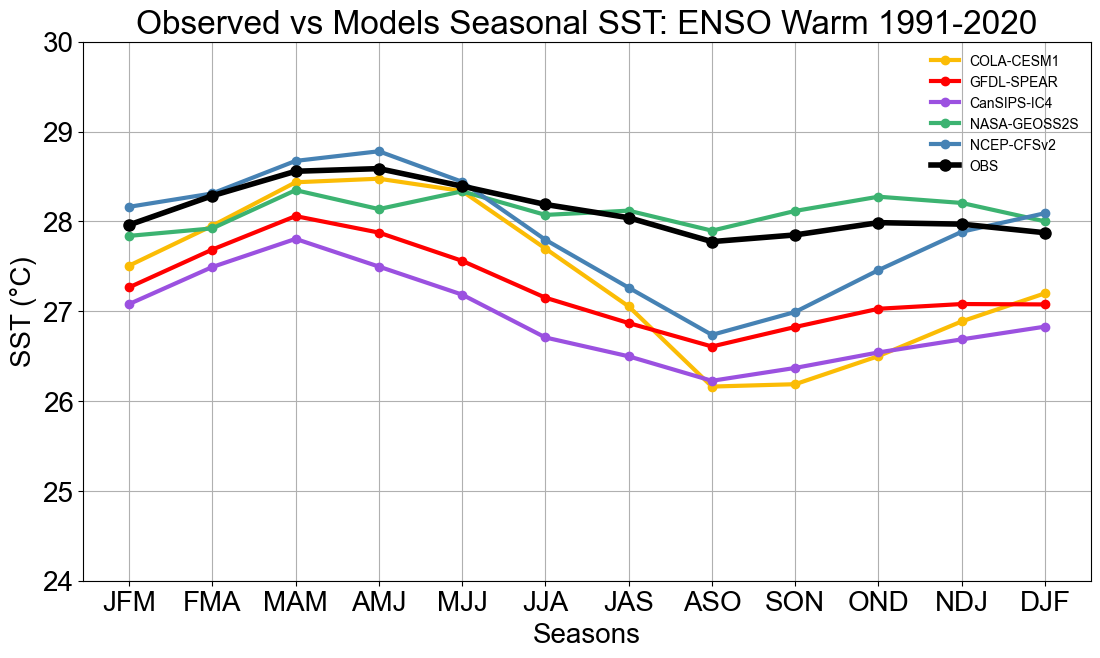

In [82]:
def warm_phase_visualizer():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    plt.plot(cola_warm_mean['SZN'], cola_warm_mean[f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_warm_mean['SZN'], gfdl_warm_mean[f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_warm_mean['SZN'], canada_warm_mean[f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_warm_mean['SZN'], nasa_warm_mean[f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_warm_mean['SZN'], ncep_warm_mean[f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(warm_mean_obs['SZN'], warm_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    
    
    # Customize the plot
    plt.title(f'Observed vs Models Seasonal SST: ENSO Warm 1991-2020', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=24, ymax = 30)
    plt.savefig(f'../Plots/Obs/warm_models_and_observed_mean.png', format='png')
    # Show the plot
    plt.show()

warm_phase_visualizer()

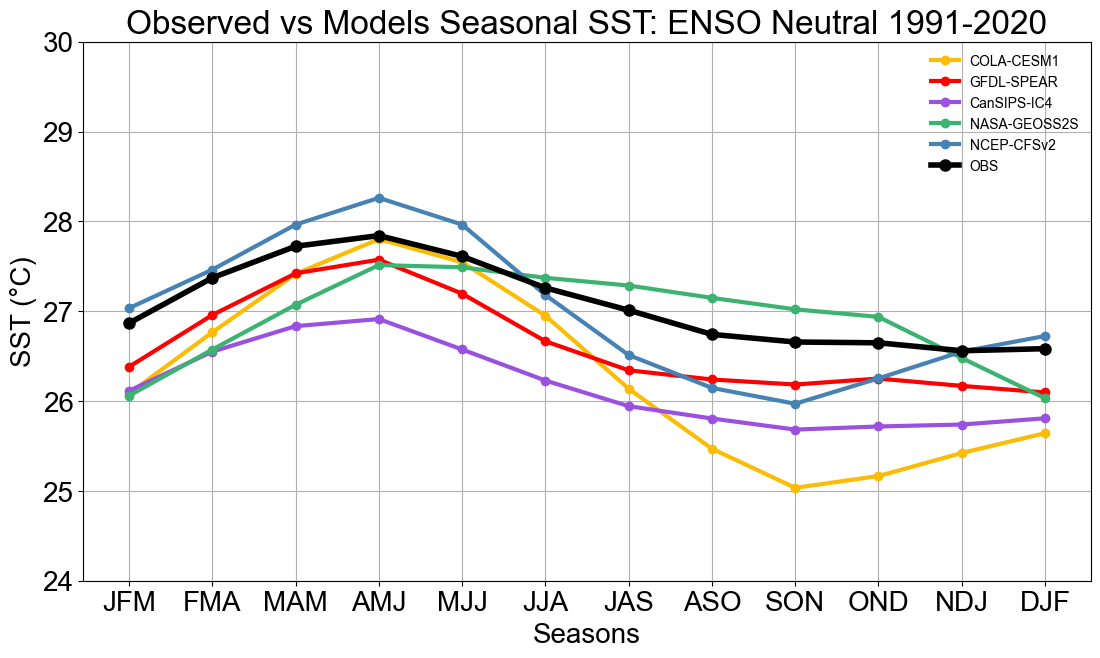

In [83]:
def neutral_phase_visualizer():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    
    plt.plot(cola_neutral_mean['SZN'], cola_neutral_mean[f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_neutral_mean['SZN'], gfdl_neutral_mean[f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_neutral_mean['SZN'], canada_neutral_mean[f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_neutral_mean['SZN'], nasa_neutral_mean[f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_neutral_mean['SZN'], ncep_neutral_mean[f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(neutral_mean_obs['SZN'], neutral_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    # Customize the plot
    plt.title(f'Observed vs Models Seasonal SST: ENSO Neutral 1991-2020', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=24, ymax = 30)
    plt.savefig(f'../Plots/Obs/neutral_models_and_observed_mean.png', format='png')
    # Show the plot
    plt.show()
neutral_phase_visualizer()

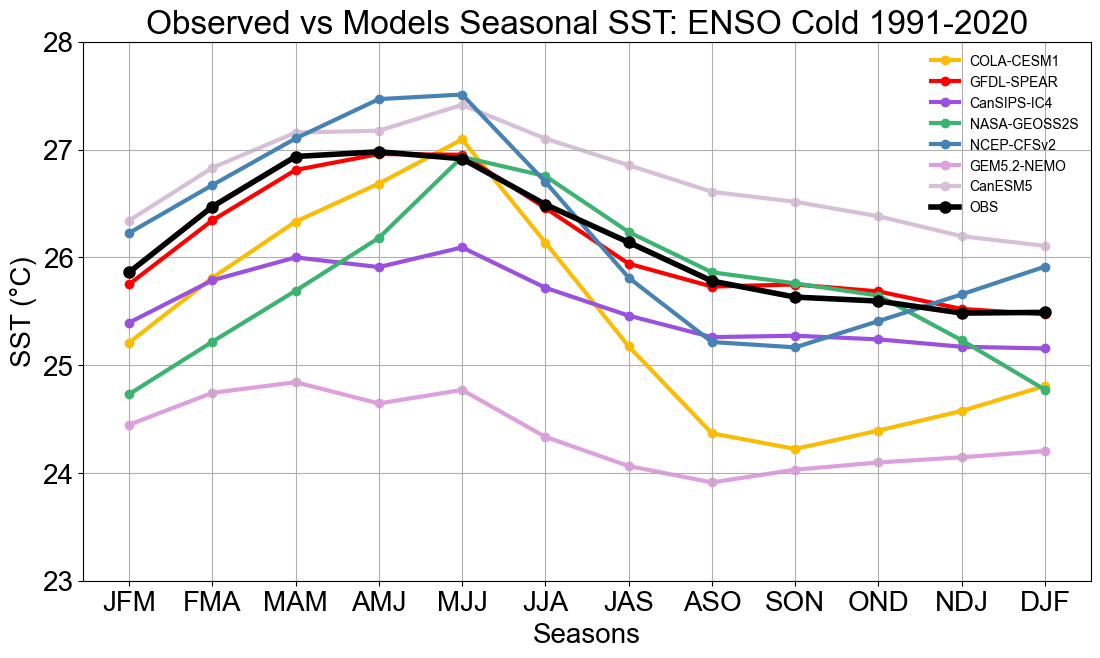

In [84]:
def cold_phase_visualizer():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    
    plt.plot(cola_cold_mean['SZN'], cola_cold_mean[f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_cold_mean['SZN'], gfdl_cold_mean[f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_cold_mean['SZN'], canada_cold_mean[f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_cold_mean['SZN'], nasa_cold_mean[f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_cold_mean['SZN'], ncep_cold_mean[f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(nemo_cold_mean['SZN'], nemo_cold_mean['LDC_SST_GEM52_NEMO'], marker='o',markersize=6, linewidth=3, linestyle='-', color='plum' ,label = 'GEM5.2-NEMO', zorder=1)
    plt.plot(canesm_cold_mean['SZN'], canesm_cold_mean['LDC_SST_CanESM5'], marker='o',markersize=6, linewidth=3, linestyle='-', color='thistle' ,label = 'CanESM5', zorder=1)
    
    plt.plot(cold_mean_obs['SZN'], cold_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    
    # Customize the plot
    plt.title(f'Observed vs Models Seasonal SST: ENSO Cold 1991-2020', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=23, ymax = 28)
    plt.savefig(f'../Plots/Obs/cold_models_and_observed_mean_lead{lead}.png', format='png')
    # Show the plot
    plt.show()

cold_phase_visualizer()


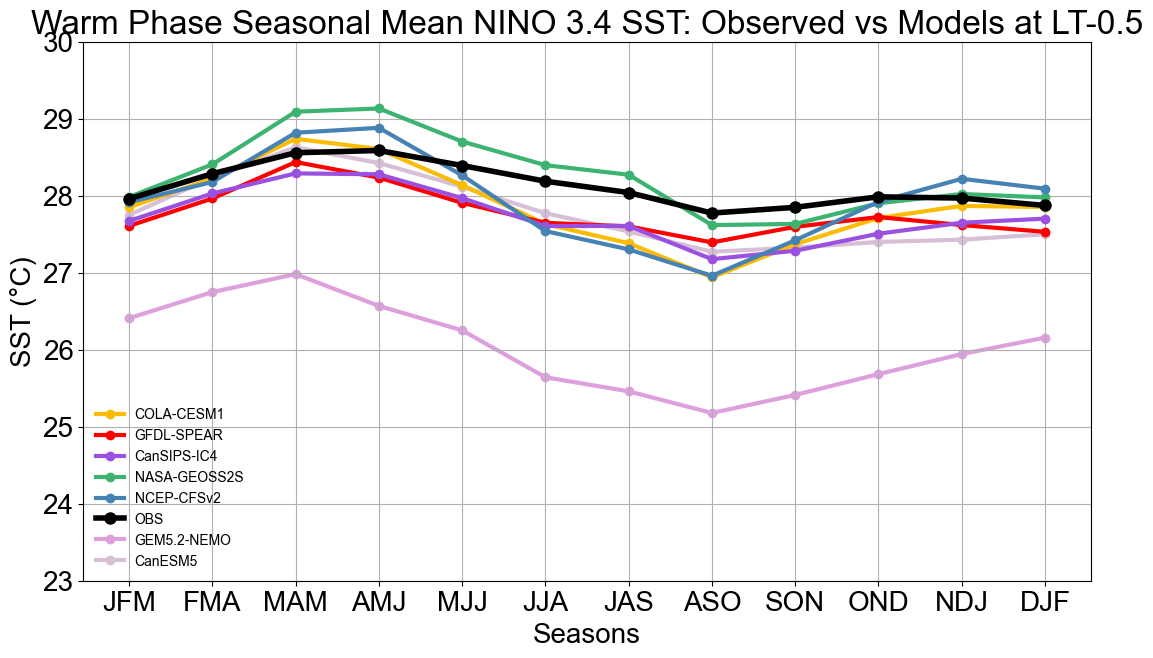

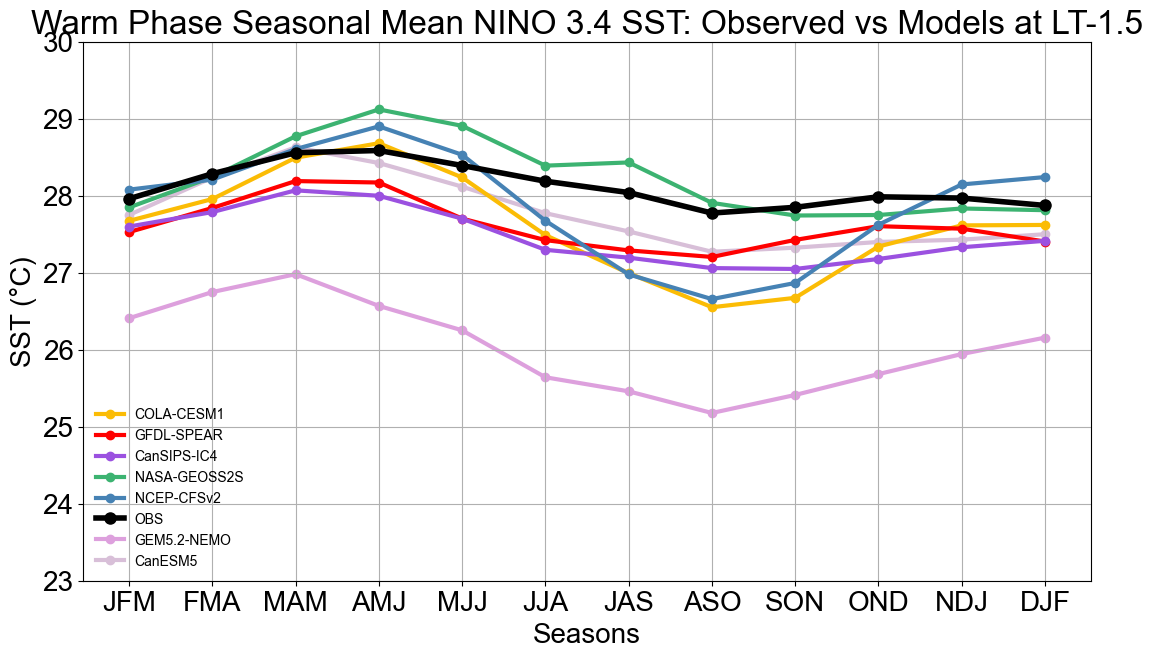

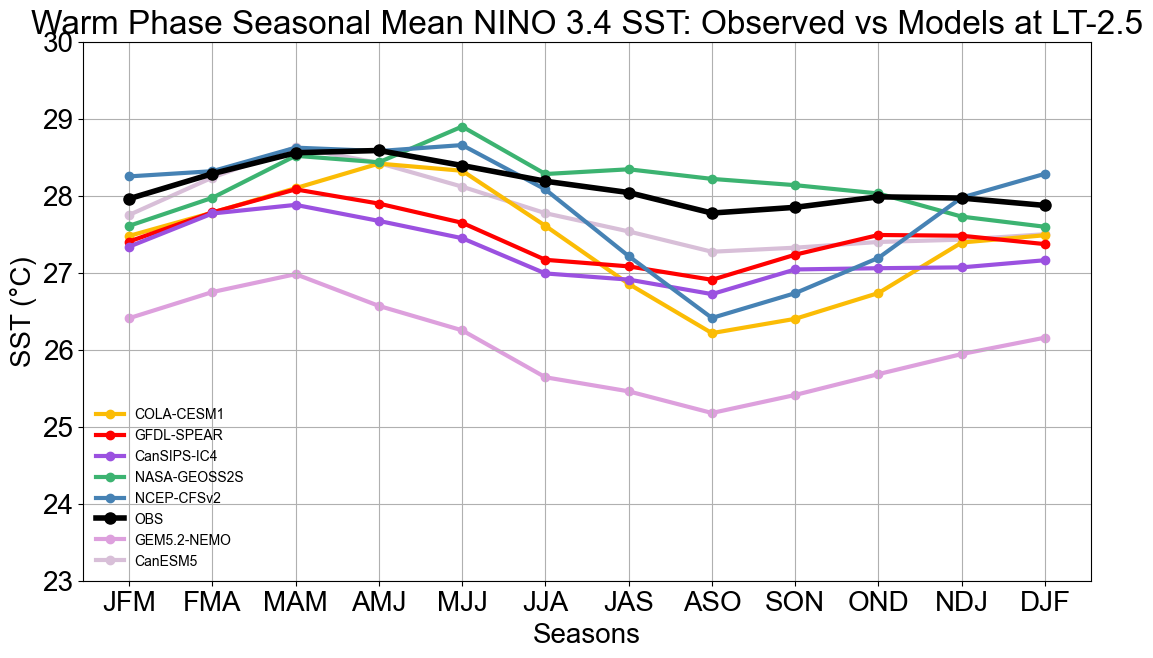

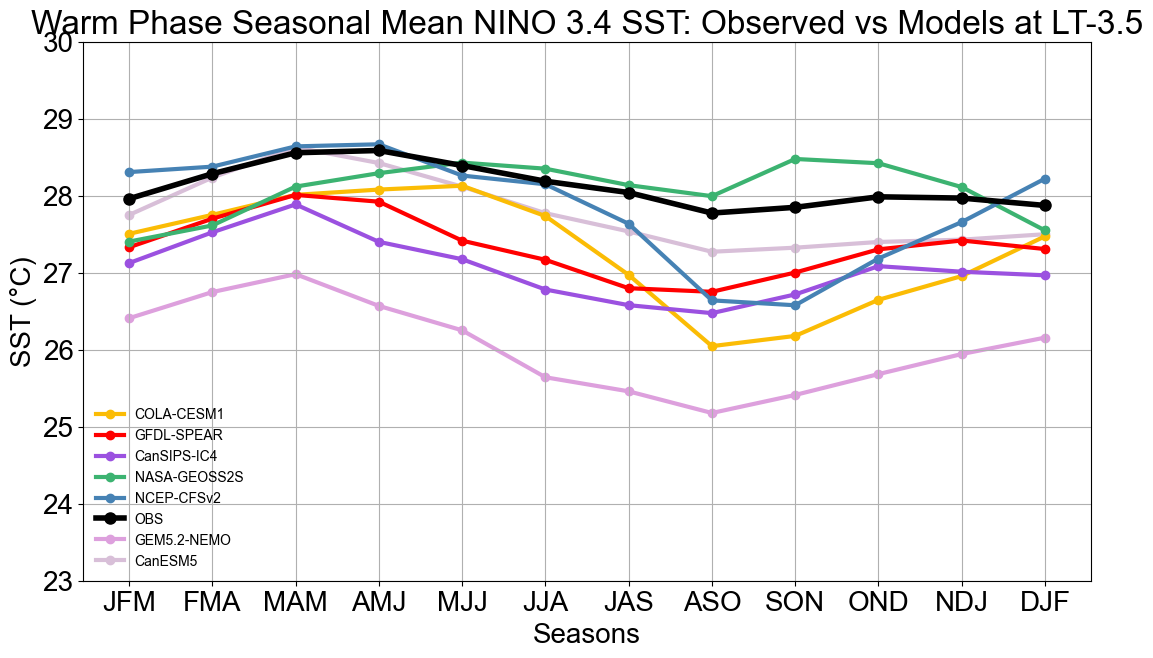

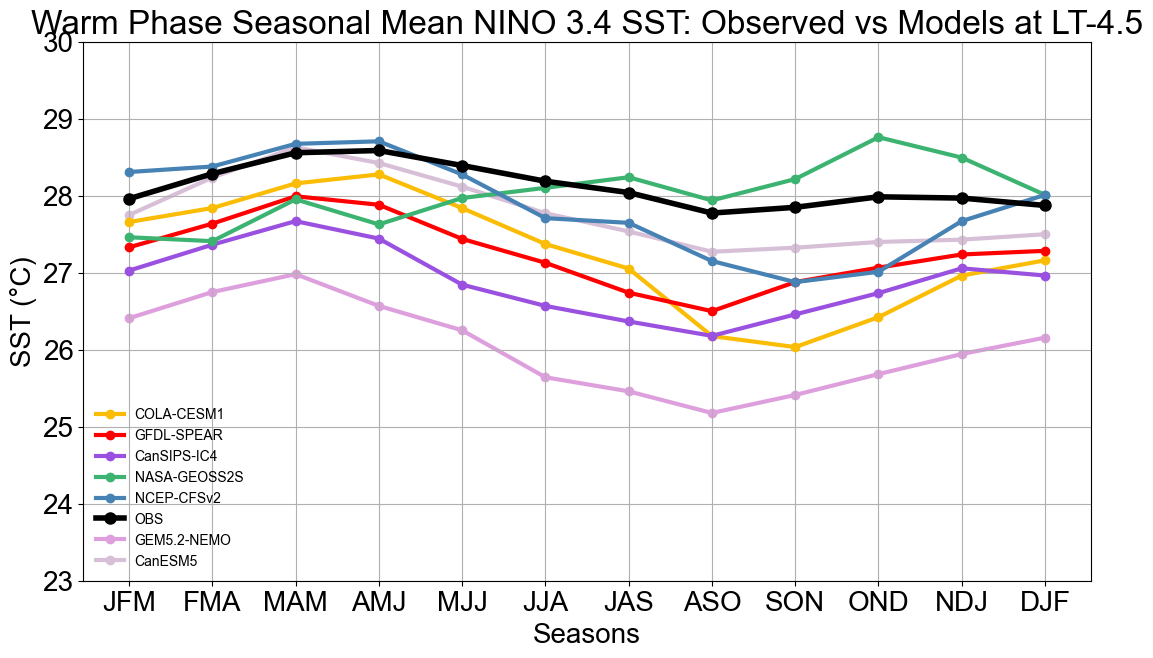

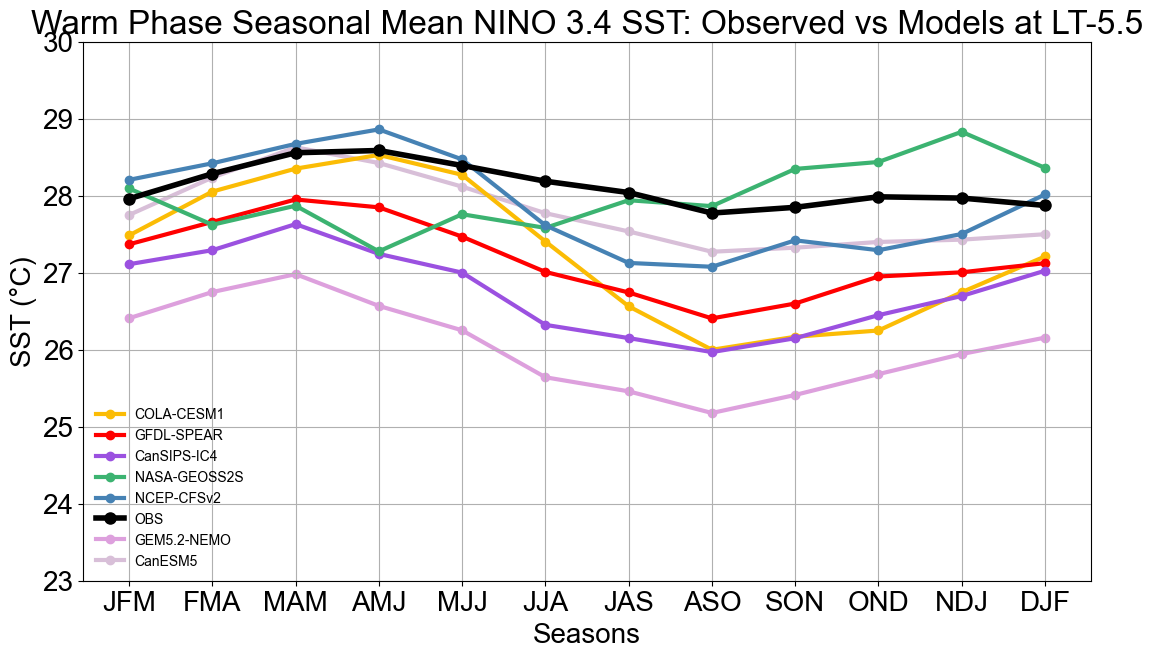

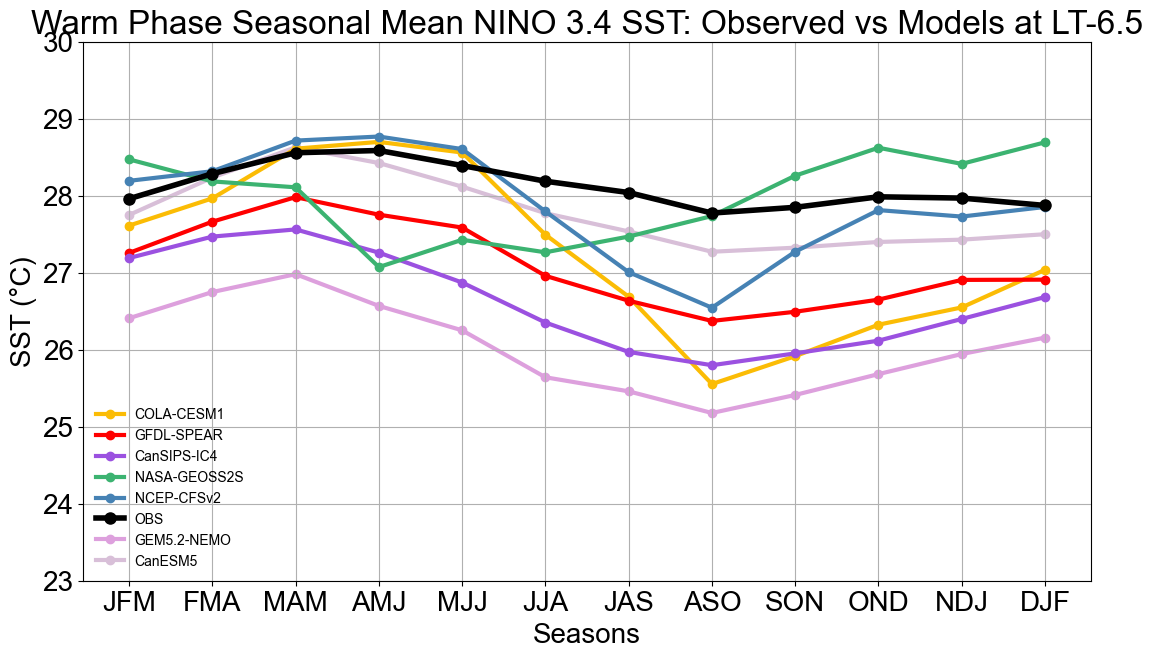

In [91]:
def warm_phase_ldc_visualizer(lead):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    plt.plot(cola_warm_mean['SZN'], cola_warm_dfs[f'lead{lead}'][f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_warm_mean['SZN'], gfdl_warm_dfs[f'lead{lead}'][f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_warm_mean['SZN'], canada_warm_dfs[f'lead{lead}'][f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_warm_mean['SZN'], nasa_warm_dfs[f'lead{lead}'][f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_warm_mean['SZN'], ncep_warm_dfs[f'lead{lead}'][f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(warm_mean_obs['SZN'], warm_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    plt.plot(nemo_warm_mean['SZN'], nemo_warm_mean['LDC_SST_GEM52_NEMO'], marker='o',markersize=6, linewidth=3, linestyle='-', color='plum' ,label = 'GEM5.2-NEMO', zorder=1)
    plt.plot(canesm_warm_mean['SZN'], canesm_warm_mean['LDC_SST_CanESM5'], marker='o',markersize=6, linewidth=3, linestyle='-', color='thistle' ,label = 'CanESM5', zorder=1)

    
    
    # Customize the plot
    plt.title(f'Warm Phase Seasonal Mean NINO 3.4 SST: Observed vs Models at LT-{lead-0.5}', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=23, ymax = 30)
    plt.savefig(f'../Plots/Mean/warm_models_and_observed_mean_lead{lead}.png', format='png')
    # Show the plot
    plt.show()

leads =  [1,2,3,4,5,6,7]
for lead in leads:
    warm_phase_ldc_visualizer(lead)

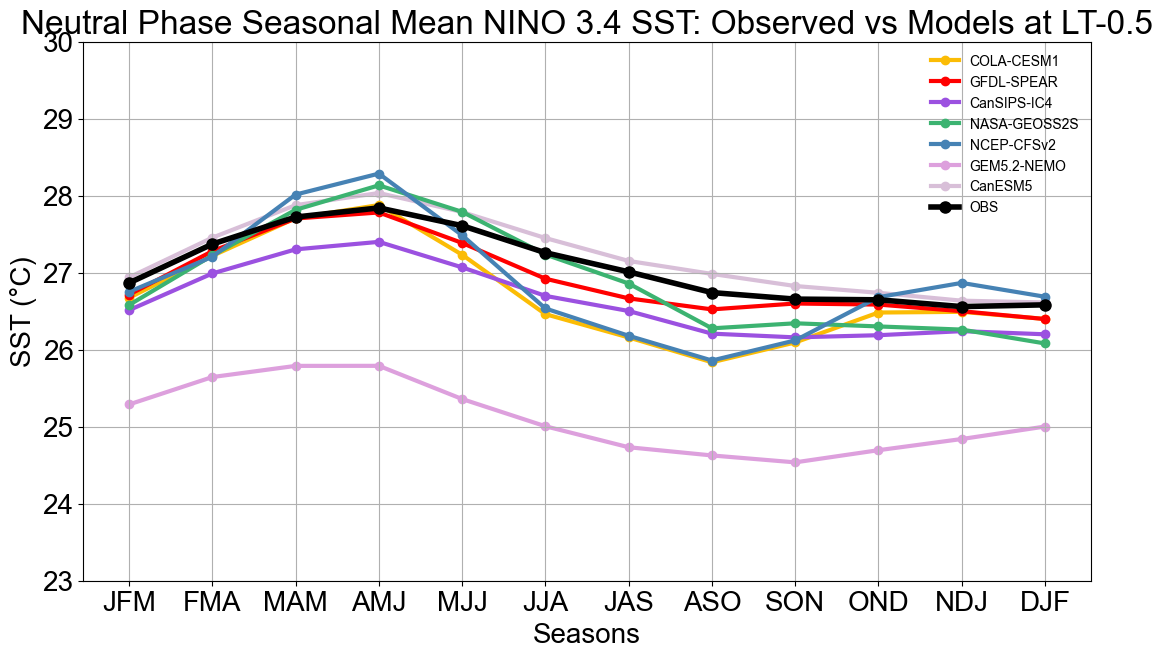

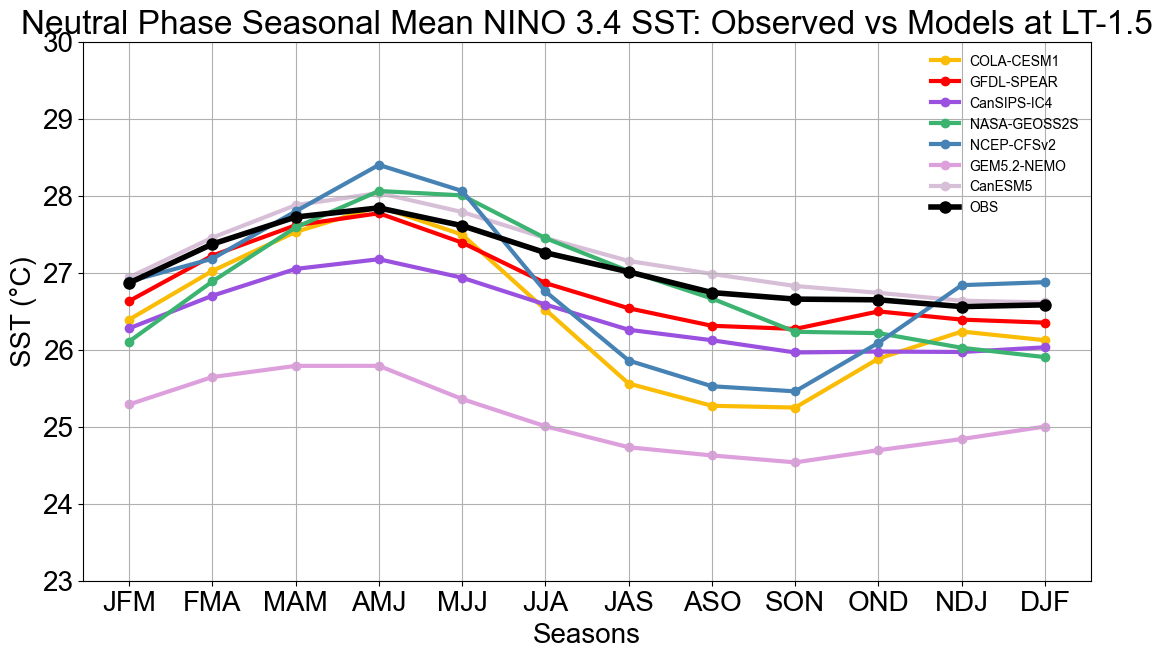

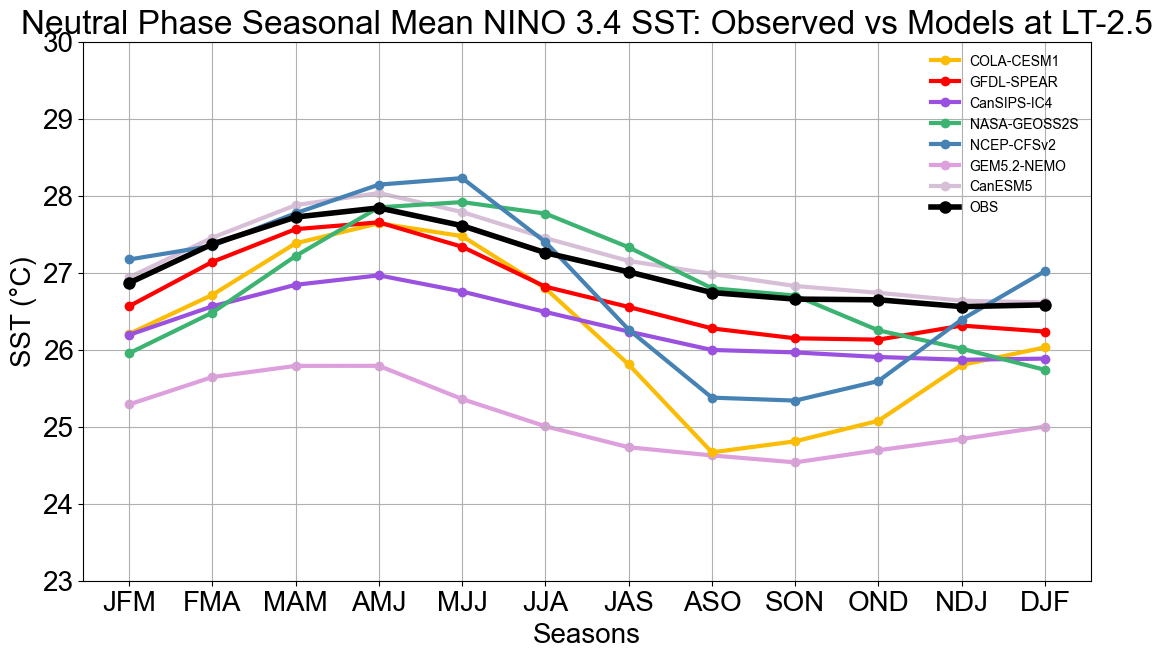

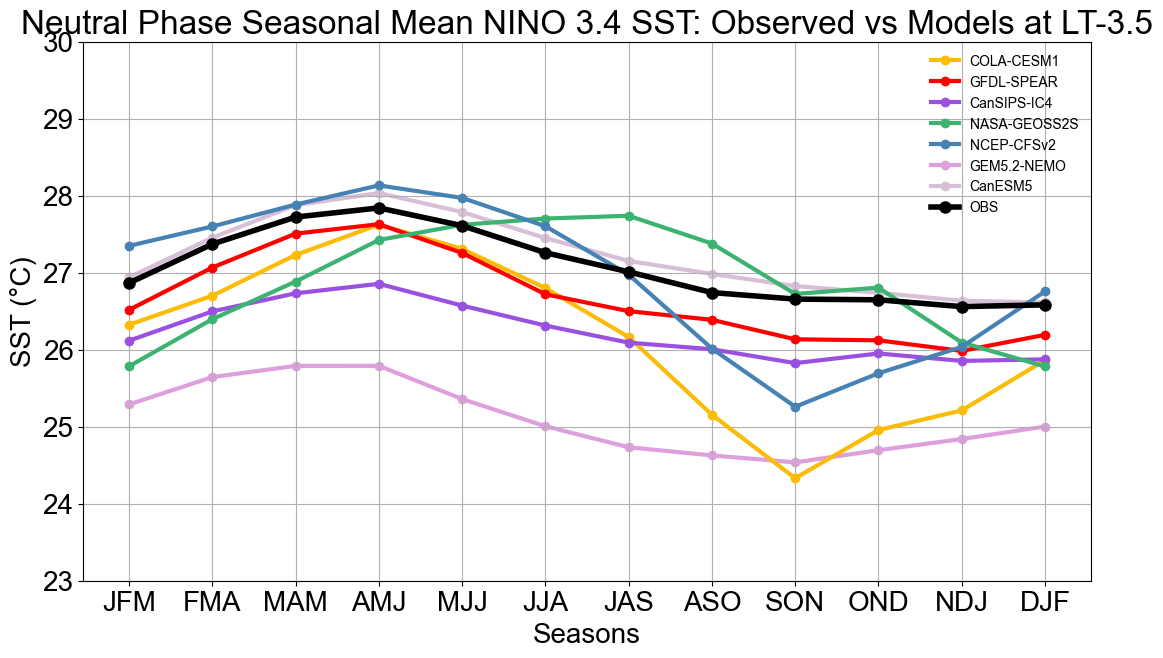

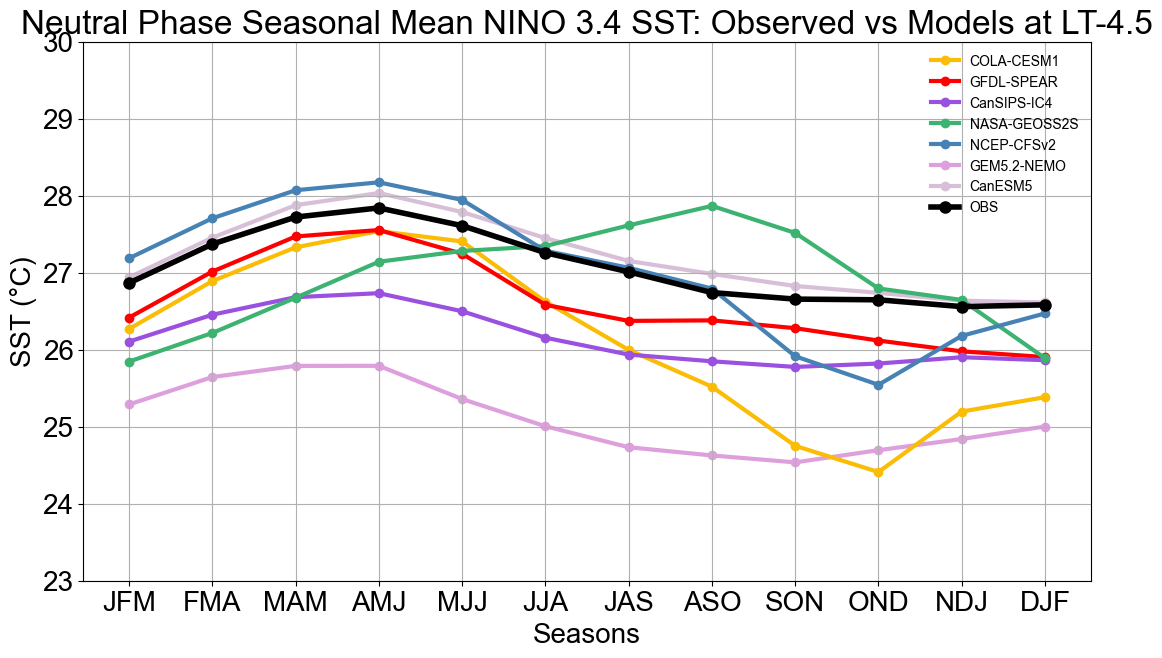

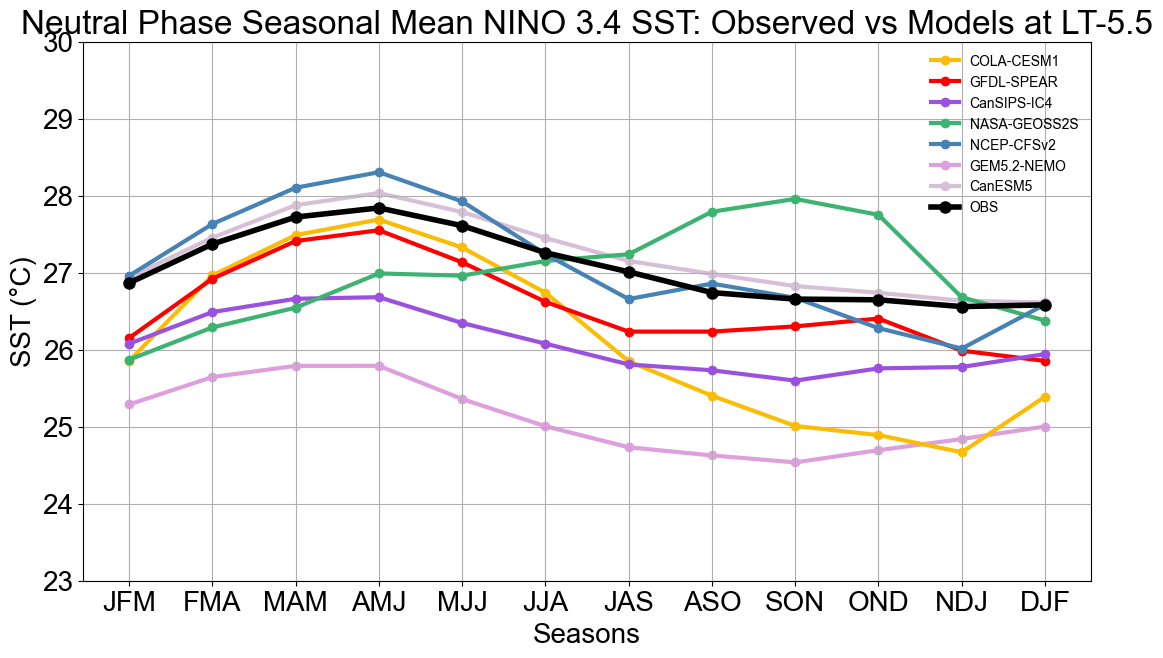

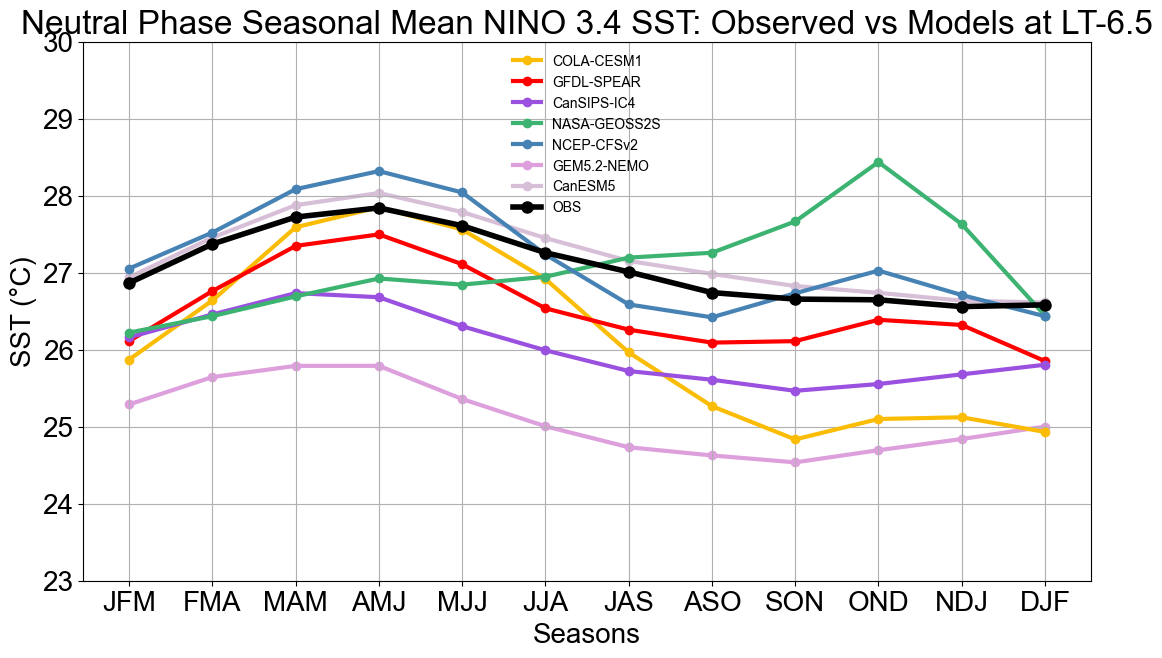

In [92]:
def neutral_phase_ldc_visualizer(lead):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    plt.plot(cola_neutral_mean['SZN'], cola_neutral_dfs[f'lead{lead}'][f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_neutral_mean['SZN'], gfdl_neutral_dfs[f'lead{lead}'][f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_neutral_mean['SZN'], canada_neutral_dfs[f'lead{lead}'][f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_neutral_mean['SZN'], nasa_neutral_dfs[f'lead{lead}'][f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_neutral_mean['SZN'], ncep_neutral_dfs[f'lead{lead}'][f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(nemo_neutral_mean['SZN'], nemo_neutral_mean['LDC_SST_GEM52_NEMO'], marker='o',markersize=6, linewidth=3, linestyle='-', color='plum' ,label = 'GEM5.2-NEMO', zorder=1)
    plt.plot(canesm_neutral_mean['SZN'], canesm_neutral_mean['LDC_SST_CanESM5'], marker='o',markersize=6, linewidth=3, linestyle='-', color='thistle' ,label = 'CanESM5', zorder=1)
    
    
    plt.plot(neutral_mean_obs['SZN'], neutral_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    
    
    # Customize the plot
    plt.title(f'Neutral Phase Seasonal Mean NINO 3.4 SST: Observed vs Models at LT-{lead-0.5}', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=23, ymax = 30)
    plt.savefig(f'../Plots/Mean/neutral_models_and_observed_mean_lead{lead}.png', format='png')
    # Show the plot
    plt.show()
    
leads =  [1,2,3,4,5,6,7]
for lead in leads:
    neutral_phase_ldc_visualizer(lead)



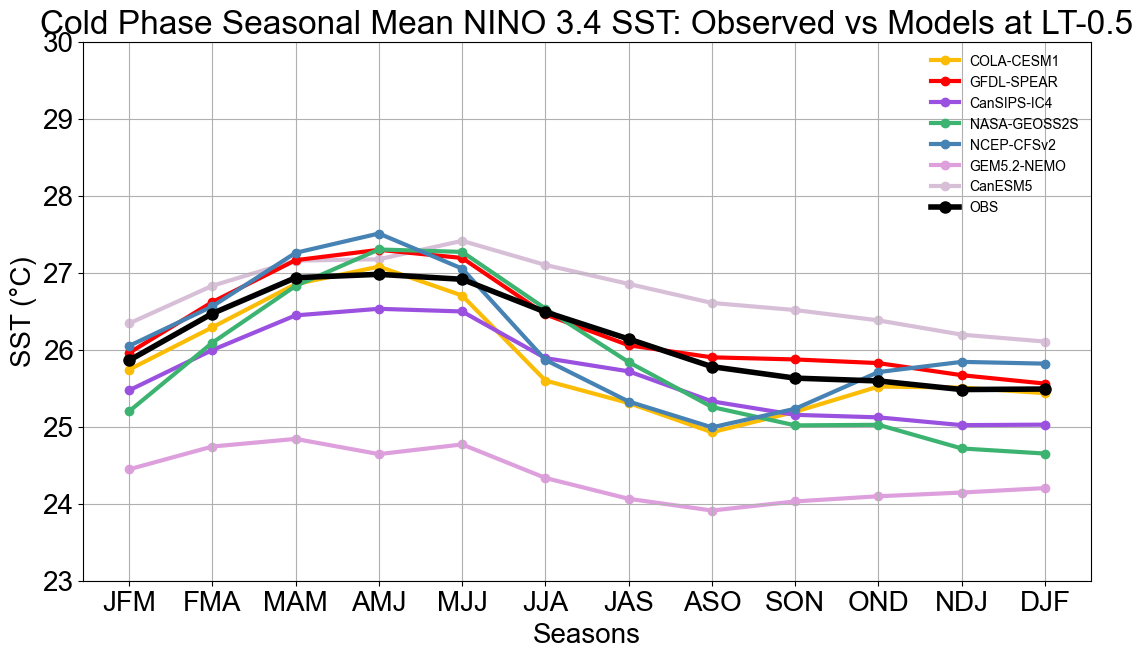

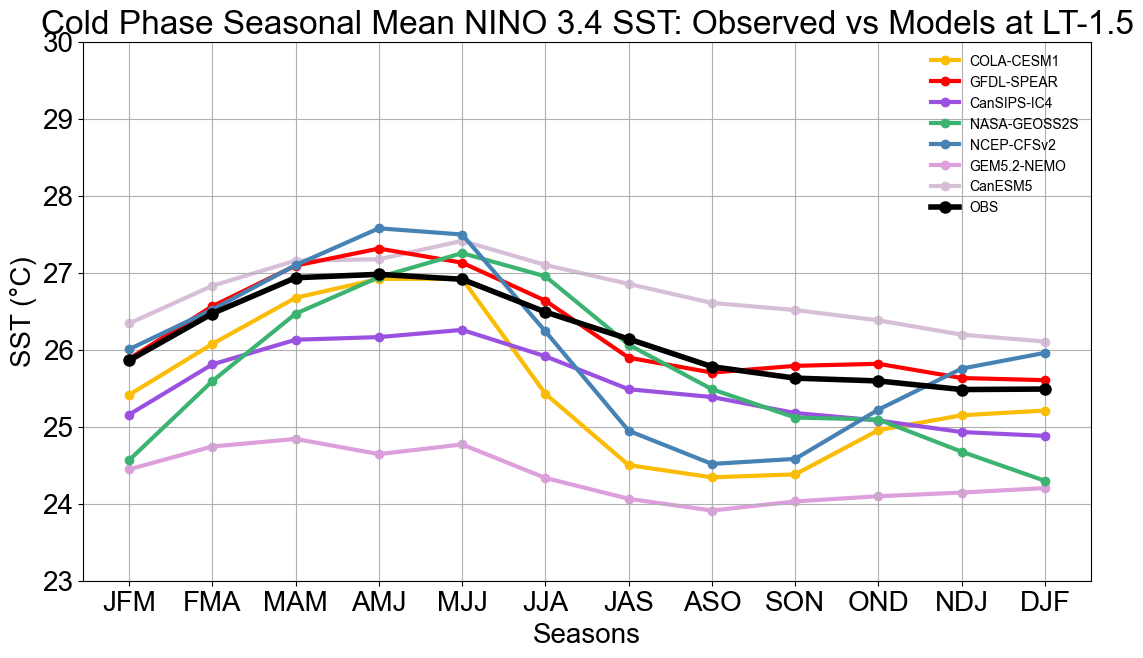

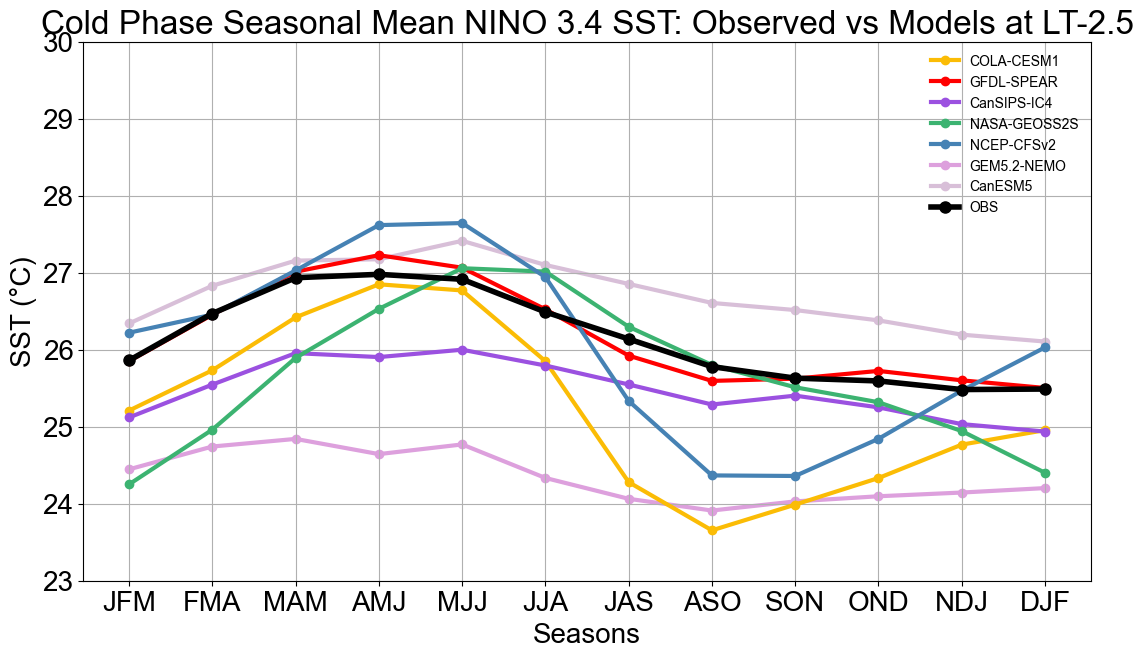

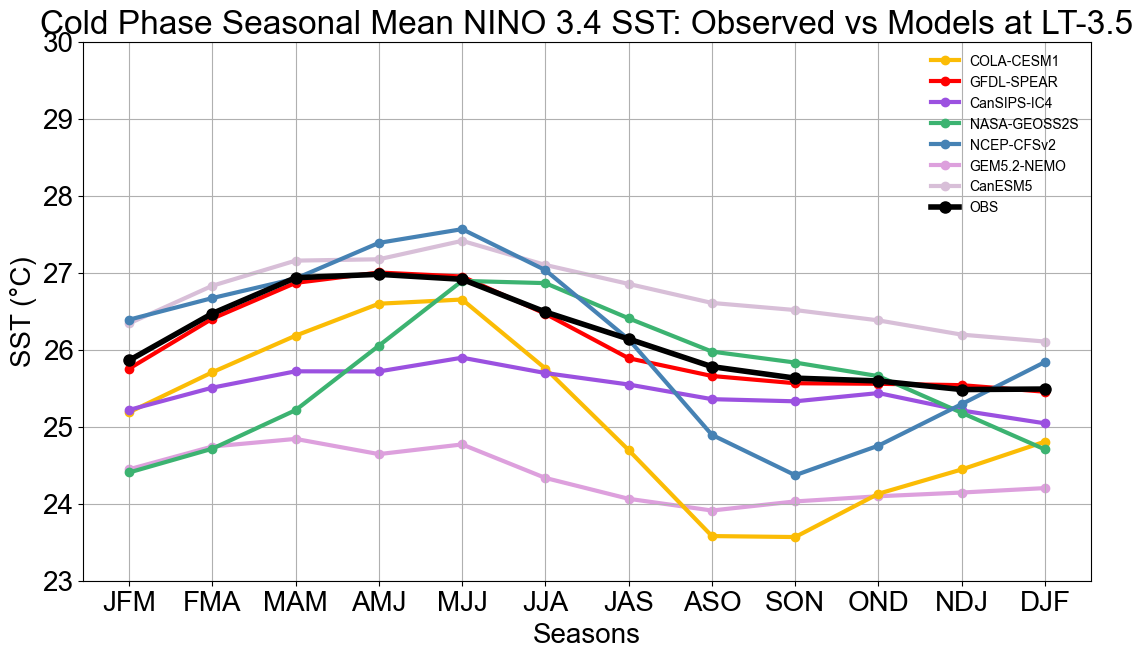

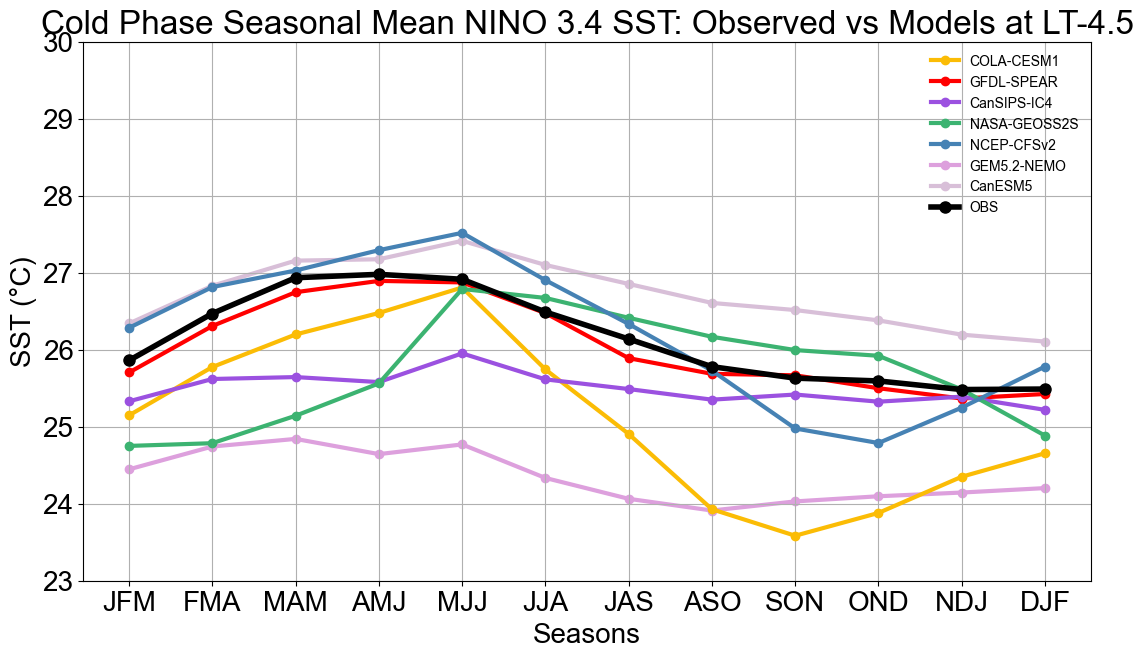

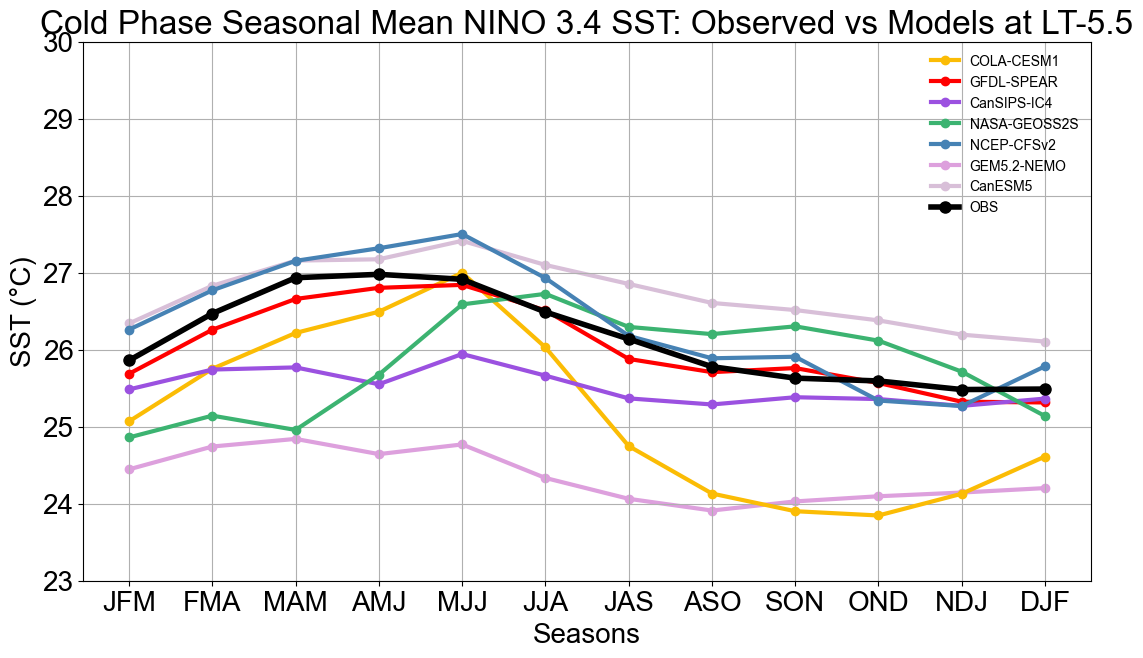

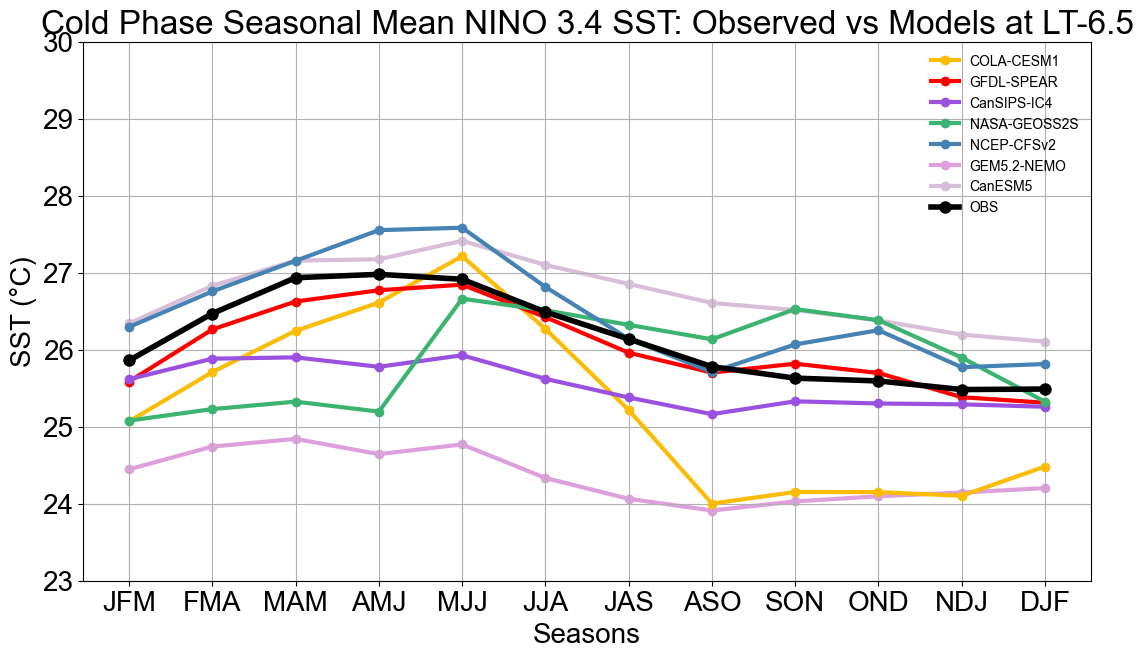

In [93]:
def cold_phase_ldc_visualizer(lead):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(13, 7))

    plt.plot(cola_cold_mean['SZN'], cola_cold_dfs[f'lead{lead}'][f'LDC_SST_COLA_CESM1'], marker='o', markersize=6, linewidth=3, linestyle='-', color='#FBBC05' ,label = 'COLA-CESM1')
    plt.plot(gfdl_cold_mean['SZN'], gfdl_cold_dfs[f'lead{lead}'][f'LDC_SST_GFDL_SPEAR'], marker='o', markersize=6, linewidth=3, linestyle='-', color='red', label = 'GFDL-SPEAR')
    plt.plot(canada_cold_mean['SZN'], canada_cold_dfs[f'lead{lead}'][f'LDC_SST_CanSIPS_IC4'], marker='o',markersize=6, linewidth=3,linestyle='-', color='#9B51E0' ,label = 'CanSIPS-IC4')
    plt.plot(nasa_cold_mean['SZN'], nasa_cold_dfs[f'lead{lead}'][f'LDC_SST_NASA_GEOSS2S'], marker='o',markersize=6, linewidth=3,linestyle='-', color='mediumseagreen' ,label = 'NASA-GEOSS2S')
    plt.plot(ncep_cold_mean['SZN'], ncep_cold_dfs[f'lead{lead}'][f'LDC_SST_NCEP_CFSv2'], marker='o', markersize=6, linewidth=3, linestyle='-', color='steelblue' ,label = 'NCEP-CFSv2')
    plt.plot(nemo_cold_mean['SZN'], nemo_cold_mean['LDC_SST_GEM52_NEMO'], marker='o',markersize=6, linewidth=3, linestyle='-', color='plum' ,label = 'GEM5.2-NEMO', zorder=1)
    plt.plot(canesm_cold_mean['SZN'], canesm_cold_mean['LDC_SST_CanESM5'], marker='o',markersize=6, linewidth=3, linestyle='-', color='thistle' ,label = 'CanESM5', zorder=1)
    
    plt.plot(cold_mean_obs['SZN'], cold_mean_obs[f'OBS_MEAN_NINO3.4_L3'], marker='o',markersize=8, linewidth=4, linestyle='-', color='black', label = 'OBS')
    
    
    # Customize the plot
    plt.title(f'Cold Phase Seasonal Mean NINO 3.4 SST: Observed vs Models at LT-{lead-0.5}', size = 24)
    plt.xlabel('Seasons', size = 20)
    plt.ylabel('SST (°C)', size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.grid(True)
    plt.legend(frameon=False)
    plt.ylim(ymin=23, ymax = 30)
    plt.savefig(f'../Plots/Mean/cold_models_and_observed_mean_lead{lead}.png', format='png')
    # Show the plot
    plt.show()
    
leads =  [1,2,3,4,5,6,7]
for lead in leads:
    cold_phase_ldc_visualizer(lead)
    


In [88]:
#bias: at overall time series, we have 30 JFMs (-> 30 bias values (M-O). We can then check minimum bias, maximum bias -> check distrubution of biases -> boxplots. 
#identify when the high error happens, (or stripplot) -> see when, how many times the big error occurs. What was the situation at that time -> start thinking about obset events. 
#models tend to be more error prone at onset time -> at transition phase -> look where the big errors are occuring. + at lnog lead time For applications it is important to see how th emodels are at OBSET / Transition.  
#check CORRELATION and BIAS

